<a href="https://colab.research.google.com/github/anya765/climate-evidence-synthesis-nlp/blob/main/mapping_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import os

if os.path.exists("/content/"):
    from google.colab import drive
    import os
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/climate-science") 

from run_cv_experiments import load_data
df = load_data(False)
df.loc[pd.isna(df["id"]), "id"] = df.loc[pd.isna(df["id"]), "OA_id"]
df["id"] = df["id"].astype(str)

df = (df
      .merge(pd.read_csv('cv_data/INCLUDE/predictions_5_splits.csv'), how="outer")
      .merge(pd.read_csv('cv_data/12/predictions_5_splits.csv'), how="outer")
     )
for pred_col in [x for x in df.columns if "_prediction" in x]:
    label_col = pred_col.replace("_prediction","")
    df.loc[pd.isna(df[pred_col]), pred_col] = df.loc[pd.isna(df[pred_col]),label_col]


df = df.loc[df["INCLUDE_prediction"]>=0.5]
print(df.shape)
df.head()

Mounted at /content/drive
(14443, 21)


,id,abstract,title,seen,INCLUDE,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES,...,OA_id,doi,publication_year,authors,INCLUDE_prediction,12 - Coastal and marine Ecosystems_prediction,12 - Human and managed_prediction,"12 - Mountains, snow and ice_prediction","12 - Rivers, lakes, and soil moisture_prediction",12 - Terrestrial ES_prediction
1,2330992.0,Mapping surface air temperature in the Antarct...,Spatial and temporal variation of surface temp...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0
2,538065.0,Snowmelt and icemelt are believed to be import...,Role of snow and glacier melt in controlling r...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,0.0
3,492113.0,Predicted decreases in water availability acro...,Chronic water stress reduces tree growth and t...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,1.0
4,37091.0,Tropical and sub-tropical fruits have received...,Conservation and sustainable use of tropical a...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,1.0
6,2364132.0,Evidence suggests that global maize yield decl...,Dissecting the nonlinear response of maize yie...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
#load index of studies to grid cells, and generate a column which for each document-place combo is
# 1 / the number of grid cells it appears in 
shp_df_matches = pd.read_csv("data/shp_df_matches.csv")
shp_df_matches["doc_share"] = shp_df_matches.groupby("doc_id")["grid_df_id"].transform(
    lambda x: 1 / x.shape[0]
)

In [ ]:
grid_df = pd.read_csv('data/grid_df.csv')

#define a function that takes a dataframe and returns a grid cell dataframe with the weighted 
#number of studies from that dataframe in each cell
def sum_studies(df, shp_df_matches, grid_df):
    sums = (shp_df_matches[shp_df_matches["doc_id"].isin(df["id"])]
     .groupby("grid_df_id")["doc_share"].sum()
    ).to_frame("n").reset_index().rename(columns={"grid_df_id": "index"})

    return grid_df.merge(sums, how="outer")

study_grid_df = sum_studies(df, shp_df_matches, grid_df)
study_grid_df.head()

,index,LAT,LON,n
0,0,-88.75,-178.75,NaN
1,1,-88.75,-176.25,NaN
2,2,-88.75,-173.75,NaN
3,3,-88.75,-171.25,NaN
4,4,-88.75,-168.75,NaN


In [ ]:
! pip install cartopy
! pip install --no-binary shapely shapely --force
! pip install shapely[vectorized]
! pip install rioxarray
! pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 6.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 48.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 34.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 46.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 58.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 3.9 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naci

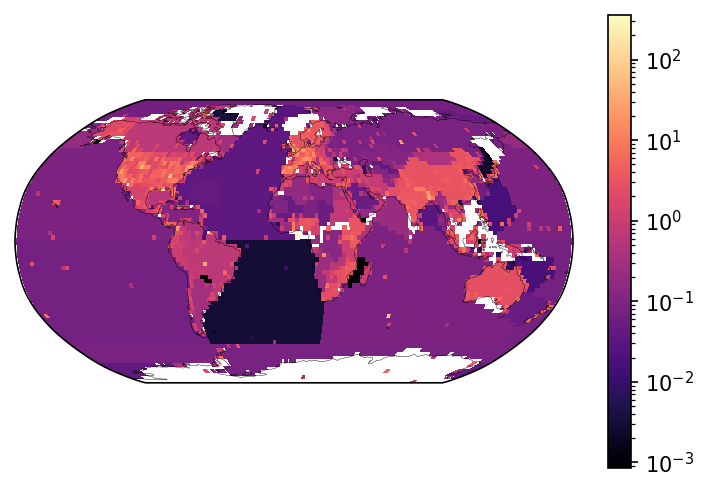

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import numpy as np

fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection=ccrs.Robinson())
ax.coastlines(lw=0.2)

shape = (len(study_grid_df.LAT.unique()), len(study_grid_df.LON.unique()))

n = np.array(study_grid_df.n).reshape(shape)

mesh=ax.pcolormesh(
    study_grid_df.LON.unique(), 
    study_grid_df.LAT.unique(), 
    n, 
    cmap=plt.cm.get_cmap('magma'),
    norm=mpl.colors.LogNorm(),
    transform=ccrs.PlateCarree(),
)

cbar = plt.colorbar(mesh)

In [ ]:
# If we want to map a subset of studies belonging to a particular class, we just need to feed this data into our function

study_grid_df = sum_studies(df[df["12 - Mountains, snow and ice"]>0.5], shp_df_matches, grid_df)

fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection=ccrs.EqualEarth())
ax.coastlines(lw=0.2)

shape = (len(study_grid_df.LAT.unique()), len(study_grid_df.LON.unique()))

n = np.array(study_grid_df.n).reshape(shape)

mesh=ax.pcolormesh(
    study_grid_df.LON.unique(), 
    study_grid_df.LAT.unique(), 
    n, 
    cmap=plt.cm.get_cmap('magma'),
    norm=mpl.colors.LogNorm(),
    transform=ccrs.PlateCarree(),
)

cbar = plt.colorbar(mesh)

ValueError: ignored

<Figure size 900x600 with 0 Axes>